# Predictive Modelling: Binary Classification with PCA

Author: Frauke Albrecht

<div>
<img src="Images/1080px-Hematopoiesis_simple.svg.png" width="600"/>
</div>

Image: "By A. Rad and M. Häggström. CC-BY-SA 3.0 license." - Image:Hematopoiesis (human) diagram.png by A. Rad, CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=7351905

**We consider the binary classification problem lymphocytes vs all the other classes using a PCA to reduce the dimension and then applying several Machine Learning algorithms.**

Our given datasets contains four different types of white blood cells. Types of leukocytes can be classified in standard ways. Two pairs of broadest categories classify them either by structure (granulocytes or agranulocytes) or by cell lineage (myeloid cells or lymphoid cells). Myeloid cells (neutrophils, monocytes, eosinophils and basophils) are distinguished from lymphoid cells (lymphocytes) by hematopoietic lineage (cellular differentiation lineage). Lymphocytes can be further classified as T cells, B cells, and natural killer cells. In the previous notebook we made a classififaction between Granulocytes and Agranulocytes, with Granolucytes being Eosinophils and Neutrophils and Agranulocytes Monocytes and Lymphocytes. **In this notebook we will consider the second classification and divide between Lymphocytes and the rest.** 

In this notebook we divide our dataset in two classes: lymphocytes and the rest and make a binary classification.  The notebook is very similar to the previous one, except that the two considered classes are not balanced and we will apply sampling to achieve a balanced dataset.

Source: https://en.wikipedia.org/wiki/White_blood_cell

## Setup

In [1]:
from glob import iglob
import pandas as pd
from mlxtend.classifier import StackingClassifier
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import precision_recall_curve, confusion_matrix, accuracy_score, classification_report, roc_auc_score, recall_score, precision_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC, LinearSVC 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# path to save preprocessed train images (as dataframe)
path_train_csv = "dataset2-master/dataset2-master/images/TRAIN/"

# pathes to augmented test images for each class, where the background color has been changed
path_test_augm_c = ["dataset2-master/dataset2-master/images/TEST/EOSINOPHIL_c/"
                   , "dataset2-master/dataset2-master/images/TEST/LYMPHOCYTE_c/"
                   , "dataset2-master/dataset2-master/images/TEST/MONOCYTE_c/"
                   , "dataset2-master/dataset2-master/images/TEST/NEUTROPHIL_c/"]

# path to save preprocessed test images (as dataframe)
path_test_csv = "dataset2-master/dataset2-master/images/TEST/Test_csv/"

## Read the Data

In [3]:
# read the data (class1)
cells1 = pd.read_csv(path_train_csv + 'train_class1_E_c.csv')
#class1 = pd.read_csv(path_train_csv + 'train_class1_E_large.csv')
print(cells1.shape)
cells1.head()

(2497, 14408)


,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,14397,14398,14399,id,class,classE,classN,classL,classM,granulocyte
0,dataset2-master/dataset2-master/images/TRAIN/t...,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,...,0.861765,0.881373,0.883333,_18_9690,1,1,0,0,0,1
1,dataset2-master/dataset2-master/images/TRAIN/t...,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,...,0.741176,0.756863,0.764706,_55_7307,1,1,0,0,0,1
2,dataset2-master/dataset2-master/images/TRAIN/t...,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,...,0.774510,0.728431,0.727451,_31_1626,1,1,0,0,0,1
3,dataset2-master/dataset2-master/images/TRAIN/t...,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,...,0.882353,0.882353,0.882353,_32_1223,1,1,0,0,0,1
4,dataset2-master/dataset2-master/images/TRAIN/t...,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,...,0.882353,0.882353,0.882353,_70_1887,1,1,0,0,0,1


In [4]:
# read the data (class2)
cells2 = pd.read_csv(path_train_csv + 'train_class2_N_c.csv')
#class2 = pd.read_csv(path_train_csv + 'train_class2_N_large.csv')
print(cells2.shape)
cells2.head()

(2499, 14408)


,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,14397,14398,14399,id,class,classE,classN,classL,classM,granulocyte
0,dataset2-master/dataset2-master/images/TRAIN/t...,0.878431,0.864706,0.868627,0.790196,0.770588,0.776471,0.801961,0.769608,0.780392,...,0.882353,0.882353,0.882353,_142_4726,2,0,1,0,0,1
1,dataset2-master/dataset2-master/images/TRAIN/t...,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.881373,0.882353,0.880392,...,0.882353,0.882353,0.882353,_129_6939,2,0,1,0,0,1
2,dataset2-master/dataset2-master/images/TRAIN/t...,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,...,0.882353,0.882353,0.882353,_34_7704,2,0,1,0,0,1
3,dataset2-master/dataset2-master/images/TRAIN/t...,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,...,0.882353,0.882353,0.882353,_155_8195,2,0,1,0,0,1
4,dataset2-master/dataset2-master/images/TRAIN/t...,0.747059,0.615686,0.635294,0.733333,0.625490,0.707843,0.785294,0.724510,0.802941,...,0.882353,0.882353,0.882353,_45_3300,2,0,1,0,0,1


In [5]:
# read the data (class3)
cells3 = pd.read_csv(path_train_csv + 'train_class3_L_c.csv')
#class3 = pd.read_csv(path_train_csv + 'train_class3_L_large.csv')
print(cells3.shape)
cells3.head()

(2483, 14408)


,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,14397,14398,14399,id,class,classE,classN,classL,classM,granulocyte
0,dataset2-master/dataset2-master/images/TRAIN/t...,0.703922,0.617647,0.594118,0.711765,0.535294,0.535294,0.698039,0.535294,0.521569,...,0.773529,0.697059,0.682353,_6_1405,3,0,0,1,0,0
1,dataset2-master/dataset2-master/images/TRAIN/t...,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,...,0.882353,0.882353,0.882353,_13_4518,3,0,0,1,0,0
2,dataset2-master/dataset2-master/images/TRAIN/t...,0.772549,0.622549,0.623529,0.754902,0.602941,0.615686,0.767647,0.616667,0.615686,...,0.882353,0.882353,0.882353,_19_3956,3,0,0,1,0,0
3,dataset2-master/dataset2-master/images/TRAIN/t...,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,...,0.882353,0.882353,0.882353,_12_5987,3,0,0,1,0,0
4,dataset2-master/dataset2-master/images/TRAIN/t...,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,...,0.872549,0.882353,0.878431,_20_4702,3,0,0,1,0,0


In [6]:
# read the data (class4)
cells4 = pd.read_csv(path_train_csv + 'train_class4_M_c.csv')
#class4 = pd.read_csv(path_train_csv + 'train_class4_M_large.csv')
print(cells4.shape)
cells4.head()

(2478, 14408)


,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,14397,14398,14399,id,class,classE,classN,classL,classM,granulocyte
0,dataset2-master/dataset2-master/images/TRAIN/t...,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.880392,0.881373,...,0.882353,0.882353,0.882353,_4_825,4,0,0,0,1,0
1,dataset2-master/dataset2-master/images/TRAIN/t...,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.881373,0.881373,0.881373,...,0.881373,0.881373,0.881373,_3_8282,4,0,0,0,1,0
2,dataset2-master/dataset2-master/images/TRAIN/t...,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,...,0.882353,0.882353,0.882353,_8_9083,4,0,0,0,1,0
3,dataset2-master/dataset2-master/images/TRAIN/t...,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.881373,0.882353,0.880392,...,0.702941,0.638235,0.637255,_9_5268,4,0,0,0,1,0
4,dataset2-master/dataset2-master/images/TRAIN/t...,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,...,0.882353,0.882353,0.882353,_13_9280,4,0,0,0,1,0


In [7]:
# save all in 1 dataframe and delete the others
blood = cells1.copy()
blood = blood.append(cells2)
del cells1
blood = blood.append(cells3)
del cells2
blood = blood.append(cells4)
del cells3
del cells4
blood.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,14397,14398,14399,id,class,classE,classN,classL,classM,granulocyte
0,dataset2-master/dataset2-master/images/TRAIN/t...,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,...,0.861765,0.881373,0.883333,_18_9690,1,1,0,0,0,1
1,dataset2-master/dataset2-master/images/TRAIN/t...,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,...,0.741176,0.756863,0.764706,_55_7307,1,1,0,0,0,1
2,dataset2-master/dataset2-master/images/TRAIN/t...,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,...,0.774510,0.728431,0.727451,_31_1626,1,1,0,0,0,1
3,dataset2-master/dataset2-master/images/TRAIN/t...,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,...,0.882353,0.882353,0.882353,_32_1223,1,1,0,0,0,1
4,dataset2-master/dataset2-master/images/TRAIN/t...,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,...,0.882353,0.882353,0.882353,_70_1887,1,1,0,0,0,1


Lymphocytes: [0 1]


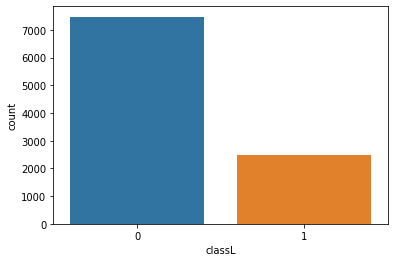

In [8]:
# the data is unbalanced
print("Lymphocytes: " + str(blood["classL"].unique()))
sns.countplot(x = blood["classL"]);

## Sampling

Since the class Lymphocytes is underrepresented in the dataset we will under-sample the other class, so that we get a balanced dataset.

Random under-sampling:
1    2483
0    2483
Name: classL, dtype: int64


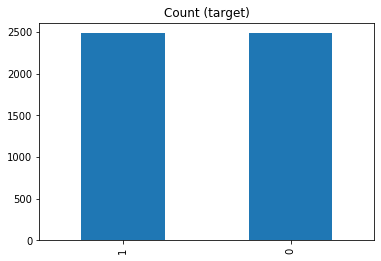

In [9]:
# under sampling

# class count
count_classL_0, count_classL_1 = blood["classL"].value_counts()

# divide by class
df_classL_0 = blood[blood['classL'] == 0]
df_classL_1 = blood[blood['classL'] == 1]

# select count_classL_1 elements from class 0, so that both classes have the same number of observations
df_classL_0_under = df_classL_0.sample(count_classL_1)
blood_under = pd.concat([df_classL_0_under, df_classL_1], axis=0)

print('Random under-sampling:')
print(blood_under.classL.value_counts())

blood_under.classL.value_counts().plot(kind='bar', title='Count (target)');

In [10]:
# from now on we work with the sampled dataset, so that the two classes are balanced
del blood

In [11]:
blood_under.shape

(4966, 14408)

In [12]:
blood_under.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,14397,14398,14399,id,class,classE,classN,classL,classM,granulocyte
1207,dataset2-master/dataset2-master/images/TRAIN/t...,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,...,0.833333,0.830392,0.801961,_135_2564,2,0,1,0,0,1
1519,dataset2-master/dataset2-master/images/TRAIN/t...,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,...,0.882353,0.882353,0.882353,_63_151,2,0,1,0,0,1
252,dataset2-master/dataset2-master/images/TRAIN/t...,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,...,0.882353,0.882353,0.882353,_21_2869,1,1,0,0,0,1
643,dataset2-master/dataset2-master/images/TRAIN/t...,0.733333,0.778431,0.715686,0.747059,0.775490,0.713725,0.769608,0.774510,0.711765,...,0.801961,0.760784,0.781373,_15_9507,4,0,0,0,1,0
1813,dataset2-master/dataset2-master/images/TRAIN/t...,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,...,0.882353,0.882353,0.882353,_11_6158,2,0,1,0,0,1


Lymphocyte classes: [0 1]


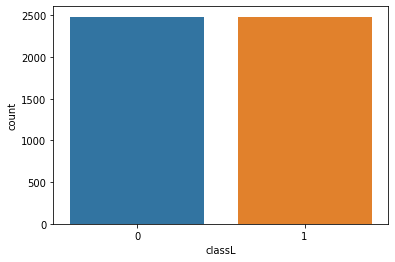

In [13]:
# now the data is balanced
print("Lymphocyte classes: " + str(blood_under["classL"].unique()))
sns.countplot(x = blood_under["classL"]);

## baseline Model

### Metrics 

In order to define a baseline model, we need to decide for a metric, which we want to maximize. As base metrics we will consider the **accuracy** and the **auc score**. The accuracy gives the percentage of correct classification. Additionally, the auc score helps to select only models that achieve false positive and true positive rates (also called recall or sensitivity) that are above random chance. This is not guaranteed for accuracy. The **recall**  gives us the number of true positive tests compared to all positives. This metric is interesting, if you are trying to detect a desease and want to be sure to test everyone, who actaully has the desease as positive. The **precision** gives us the rate of all true positve tests to all positive tests. A high precision means a low false positive tests, which would be the objective, if you only want to get positive tests, when the person is really positive. Since our classification is no test in the sense of positive and negative results, that is there none of the classes is more important, we will rely on the **accuray and the auc score**. To get the baseline accuracy we will use the model that always predicts the majority class. Since our distribution equally distributed by construction the **baseline accuracy is 0.5**. The **auc score** of a random choice would be **0.5**, which we will use as the base value.

## Prepare the data for modelling

Note: We don't need to safe a test set as we already have a separate dataset given for testing. 

The data is ordered, since all Lymphocytes are in the second half of the dataframe, so the first step we have to do is to shuffle the dataframe. We then define the features (the pixels) and the target (classL). A Pricipal Component Analysis (PCA) is then performed to reduce the dimension of the features. This is done together with a cross-validation with 5 folds. The results of the PCA are shown for the 5 folds.

### Shuffle the data

The data is shuffled by sampling the observations over the entire size of the dataframe.

In [14]:
# shuffle the data
blood_under = blood_under.sample(frac=1).reset_index(drop=True)
blood_under.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,14397,14398,14399,id,class,classE,classN,classL,classM,granulocyte
0,dataset2-master/dataset2-master/images/TRAIN/t...,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,...,0.748039,0.770588,0.724510,_34_3770,1,1,0,0,0,1
1,dataset2-master/dataset2-master/images/TRAIN/t...,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.880392,0.880392,0.880392,...,0.882353,0.882353,0.882353,_5_9971,4,0,0,0,1,0
2,dataset2-master/dataset2-master/images/TRAIN/t...,0.880392,0.880392,0.880392,0.878431,0.878431,0.878431,0.879412,0.879412,0.879412,...,0.771569,0.676471,0.662745,_3_1321,3,0,0,1,0,0
3,dataset2-master/dataset2-master/images/TRAIN/t...,0.882353,0.878431,0.869608,0.880392,0.876471,0.876471,0.834314,0.820588,0.810784,...,0.833333,0.829412,0.815686,_88_1825,2,0,1,0,0,1
4,dataset2-master/dataset2-master/images/TRAIN/t...,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,...,0.882353,0.882353,0.882353,_12_8267,3,0,0,1,0,0


### Define Features and Target

The positions of the features (pixels) and the target (classL) are set.

In [15]:
# Which indices do we need for the features? (=pixels)
blood_under.iloc[:,1:14401].head()

,0,1,2,3,4,5,6,7,8,9,...,14390,14391,14392,14393,14394,14395,14396,14397,14398,14399
0,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,...,0.615686,0.697059,0.633333,0.615686,0.749020,0.724510,0.685294,0.748039,0.770588,0.724510
1,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.880392,0.880392,0.880392,0.878431,...,0.859804,0.878431,0.878431,0.878431,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353
2,0.880392,0.880392,0.880392,0.878431,0.878431,0.878431,0.879412,0.879412,0.879412,0.785294,...,0.687255,0.788235,0.737255,0.696078,0.796078,0.718627,0.696078,0.771569,0.676471,0.662745
3,0.882353,0.878431,0.869608,0.880392,0.876471,0.876471,0.834314,0.820588,0.810784,0.849020,...,0.845098,0.862745,0.858824,0.845098,0.841176,0.838235,0.823529,0.833333,0.829412,0.815686
4,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,...,0.882353,0.882353,0.880392,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353


In [16]:
# Which index do we need for the target? (=classL)
blood_under.iloc[:,14405].head()

0    0
1    0
2    1
3    0
4    1
Name: classL, dtype: int64

In [17]:
start_f = 1
end_f = 14401
idx_t = 14405

### Principal Component Analysis

The PCA is depending on the underlying dataset, that is performing the PCA to different parts of the data might lead to different results. To test the robustness of the PCA we use 5 subsets of it and perform it on each one with 90% of the explained variance. The results show that for all folds the feature importance resulting from the PCA is very similar (only marginal differences). The eigenvectors also look very similar (except sign differences). This leads to the conclusion that this is a robust operation and confirms the assumption that we can apply this transformation also to the test data. 

In [18]:
# kfold cross validation with 5 folds
# save pca components in dictionary pca_components = {'train/test_kfold': {train/test data}} 
# save y_train in dictionary y_cv = {'train/test_kfold': {train/test data}} 
kfold=5
X_cf = {}
pca_transformed = {}
pca_components = {}
pca_explained_variance = {}
pca_singular_values = {}
pca_projected = {}
y_cv = {}
i=0
kf = KFold(n_splits=kfold, shuffle=True, random_state=42)
for train_index, test_index in kf.split(blood_under):
    i+=1
    print("-"*20 + str(i) + ". fold validation" + "-"*20)
    #print("TRAIN:", train_index, "TEST:", test_index)
    train = blood_under.iloc[train_index]
    test =  blood_under.iloc[test_index]
    X_train = train.iloc[:,start_f:end_f]
    X_test = test.iloc[:,start_f:end_f]
    y_train = train.iloc[:,idx_t]
    y_test = test.iloc[:,idx_t]
    X_cf["train_"+str(i)] = X_train
    X_cf["test_"+str(i)] = X_test
    # PCA
    print("start PCA")
    #n_components=0.90 means it will return the Eigenvectors that have the 90% of the variation in the dataset
    blood_pca = PCA(n_components=0.9,svd_solver = 'full')
    blood_pca.fit(X_train)
    transformed_train = blood_pca.transform(X_train)
    transformed_test = blood_pca.transform(X_test)
    #save pcs in dictionary
    pca_transformed["train_"+str(i)] = transformed_train
    pca_transformed["test_"+str(i)] = transformed_test
    #save train sets in dictionary
    y_cv["train_"+str(i)] = y_train
    y_cv["test_"+str(i)] = y_test
    print("Shape of X_train before PCA: " + str(X_train.shape))
    print("Shape of X_test before PCA: " + str(X_test.shape))
    print("Shape of X_train after PCA: " + str(transformed_train.shape))
    print("Shape of X_test after PCA: " + str(transformed_test.shape))
    pca_explained_variance[str(i)] = blood_pca.explained_variance_ratio_
    #components
    pca_components[str(i)] = blood_pca.components_
    #singular values
    pca_singular_values[str(i)] = blood_pca.singular_values_
    #reconstruct images from PCs
    projected = blood_pca.inverse_transform(transformed_train)
    pca_projected[str(i)] = projected
    print("end PCA")
    


--------------------1. fold validation--------------------
start PCA
Shape of X_train before PCA: (3972, 14400)
Shape of X_test before PCA: (994, 14400)
Shape of X_train after PCA: (3972, 348)
Shape of X_test after PCA: (994, 348)
end PCA
--------------------2. fold validation--------------------
start PCA
Shape of X_train before PCA: (3973, 14400)
Shape of X_test before PCA: (993, 14400)
Shape of X_train after PCA: (3973, 347)
Shape of X_test after PCA: (993, 347)
end PCA
--------------------3. fold validation--------------------
start PCA
Shape of X_train before PCA: (3973, 14400)
Shape of X_test before PCA: (993, 14400)
Shape of X_train after PCA: (3973, 349)
Shape of X_test after PCA: (993, 349)
end PCA
--------------------4. fold validation--------------------
start PCA
Shape of X_train before PCA: (3973, 14400)
Shape of X_test before PCA: (993, 14400)
Shape of X_train after PCA: (3973, 348)
Shape of X_test after PCA: (993, 348)
end PCA
--------------------5. fold validation------

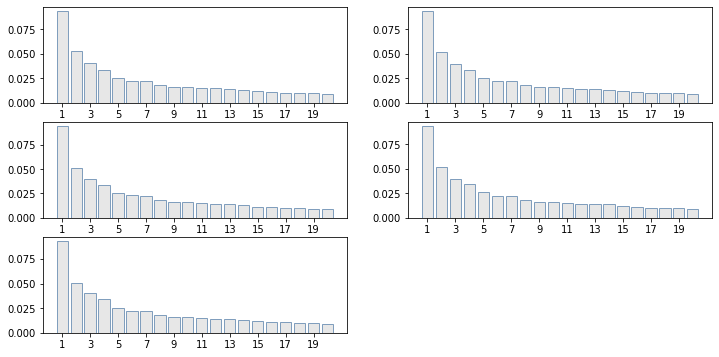

In [20]:
#importance of components
#plot explained variances of first 20 components
fig, axes = plt.subplots(3,2,figsize=(12,6))
plt.setp(axes, xticks=[1,3,5,7,9,11,13,15,17,19], xticklabels=['1', '3', '5','7','9','11','13','15','17','19'])
x = np.arange(1,21,1)
color = (0.1, 0.1, 0.1, 0.1)
edgecolor = (0.2, 0.4, 0.6, 0.6)

axes[0,0].bar(x, height=pca_explained_variance[str(1)][:20], color=color,  edgecolor=edgecolor);
axes[0,1].bar(x, height=pca_explained_variance[str(2)][:20], color=color,  edgecolor=edgecolor);
axes[1,0].bar(x, height=pca_explained_variance[str(3)][:20], color=color,  edgecolor=edgecolor);
axes[1,1].bar(x, height=pca_explained_variance[str(4)][:20], color=color,  edgecolor=edgecolor);
axes[2,0].bar(x, height=pca_explained_variance[str(5)][:20], color=color,  edgecolor=edgecolor);
fig.delaxes(axes[2,1])

In [21]:
# eigenvectors for all five folds
def plot_eigenv(comp):
    fig, axes = plt.subplots(2,10,figsize=(12,3),
    subplot_kw={'xticks':[], 'yticks':[]},
    gridspec_kw=dict(hspace=0.01, wspace=0.01))
    for i, ax in enumerate(axes.flat):
        img = comp[i].reshape(60,80,3)
        ax.imshow((img * 255).astype(np.uint8),cmap='gray')

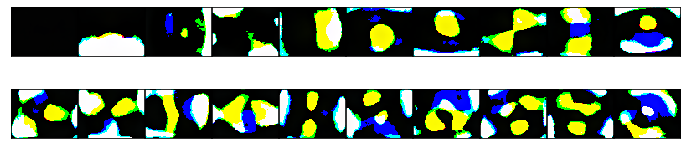

In [22]:
plot_eigenv(pca_components[str(1)])

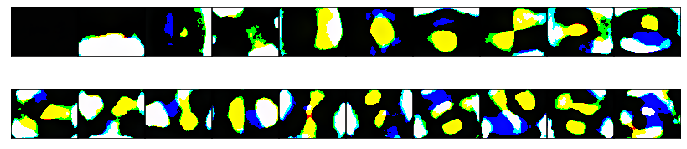

In [23]:
plot_eigenv(pca_components[str(2)])

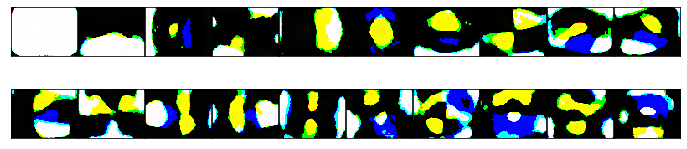

In [24]:
plot_eigenv(pca_components[str(3)])

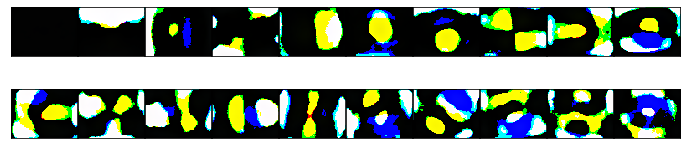

In [25]:
plot_eigenv(pca_components[str(4)])

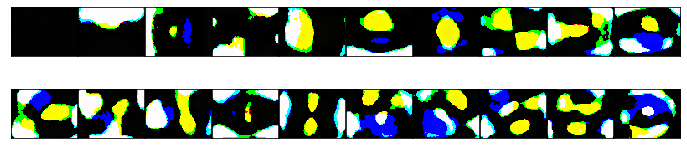

In [26]:
plot_eigenv(pca_components[str(5)])

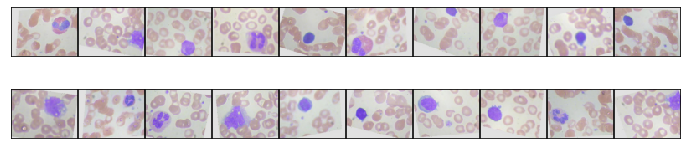

In [27]:
# images before pca
fig, axes = plt.subplots(2,10,figsize=(12,3), subplot_kw={'xticks':[], 'yticks':[]},
            gridspec_kw=dict(hspace=0.01, wspace=0.01))
for i, ax in enumerate(axes.flat):
    #img = np.asarray(blood.iloc[i,1:14401]).reshape(60,80,3)
    img = np.asarray(X_cf["train_"+str(1)])[i].reshape(60,80,3)
    ax.imshow((img * 255).astype(np.uint8))

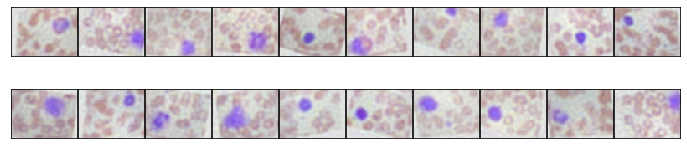

In [28]:
# reconstructed images from pca
fig, axes = plt.subplots(2, 10,figsize=(12,3), subplot_kw={'xticks':[], 'yticks':[]},
            gridspec_kw=dict(hspace=0.01, wspace=0.01))
for i, ax in enumerate(axes.flat):
    img = pca_projected[str(1)][i].reshape(60,80,3)
    ax.imshow((img * 255).astype(np.uint8))

## Model Setup

Next we set up a set of models, which are evaluated by a set of metrics. The most important metrics for our case are the **accuracy and the roc auc score**. The resulting scores for the metrics are plotted for all considered models. 

### Principal Component Analyis

We saw that the results of the PCAs on the 5-folds all were very close to each other. That is, it is a robust operation on our data. We now perform a PCA on the entire training set to reduce the dimension and then apply the models to this reduced space. 

In [29]:
# pca on entire trainingset
X_train = blood_under.iloc[:,1:14401]
X_test = blood_under.iloc[:,1:14401]
y_train = blood_under.iloc[:,14405]
y_test = blood_under.iloc[:,14405]
blood_pca = PCA(n_components=0.8,svd_solver = 'full')#0.6
blood_pca.fit(X_train)
transformed_train = blood_pca.transform(X_train)
transformed_test = blood_pca.transform(X_test)
print("Shape of X_train before PCA: " + str(X_train.shape))
print("Shape of X_test before PCA: " + str(X_test.shape))
print("Shape of X_train after PCA: " + str(transformed_train.shape))
print("Shape of X_test after PCA: " + str(transformed_test.shape))

Shape of X_train before PCA: (4966, 14400)
Shape of X_test before PCA: (4966, 14400)
Shape of X_train after PCA: (4966, 136)
Shape of X_test after PCA: (4966, 136)


In [30]:
# explained variances
print("Explained variance of first 20 components: {}".format(round(sum(blood_pca.explained_variance_ratio_[:20]),2)))
blood_pca.explained_variance_ratio_[:20]

Explained variance of first 20 components: 0.46


array([0.09325125, 0.05140218, 0.04000119, 0.03371235, 0.0252586 ,
       0.02237927, 0.02202452, 0.01794594, 0.01611221, 0.01562278,
       0.01516326, 0.01429988, 0.01363803, 0.01327325, 0.01157363,
       0.01084863, 0.0101824 , 0.01008458, 0.0094568 , 0.00887027])

Explained variance of first 20 components: 0.46


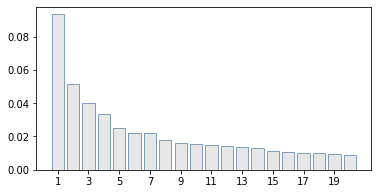

In [31]:
#importance of components
#plot explained variances of first 20 components
fig, axes = plt.subplots(1,1,figsize=(6,3))
plt.setp(axes, xticks=[1,3,5,7,9,11,13,15,17,19], xticklabels=['1', '3', '5','7','9','11','13','15','17','19'])
x = np.arange(1,21,1)
color = (0.1, 0.1, 0.1, 0.1)
edgecolor = (0.2, 0.4, 0.6, 0.6)
#x = np.arange(1,4,1)
axes.bar(x, height=blood_pca.explained_variance_ratio_[0:20], color=color,  edgecolor=edgecolor);
#axes.bar(x, height=blood_pca.explained_variance_ratio_);
print("Explained variance of first 20 components: {:.2f}".format(blood_pca.explained_variance_ratio_[0:20].sum()))

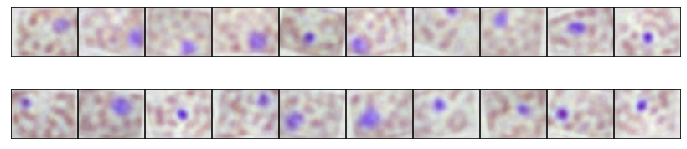

In [32]:
# reconstructed images from pca
pca_projected = blood_pca.inverse_transform(transformed_train)

fig, axes = plt.subplots(2, 10,figsize=(12,3), subplot_kw={'xticks':[], 'yticks':[]},
            gridspec_kw=dict(hspace=0.01, wspace=0.01))
for i, ax in enumerate(axes.flat):
    img = pca_projected[i].reshape(60,80,3)
    ax.imshow((img * 255).astype(np.uint8))

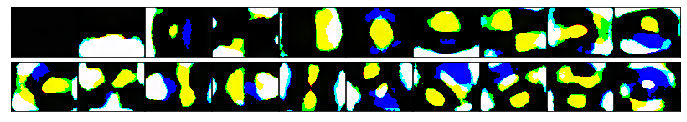

In [33]:
# eigenvectors
fig, axes = plt.subplots(2,10,figsize=(12,2),
subplot_kw={'xticks':[], 'yticks':[]},
gridspec_kw=dict(hspace=0.01, wspace=0.01))
for i, ax in enumerate(axes.flat):
    img = blood_pca.components_[i].reshape(60,80,3)
    ax.imshow((img * 255).astype(np.uint8),cmap='gray')

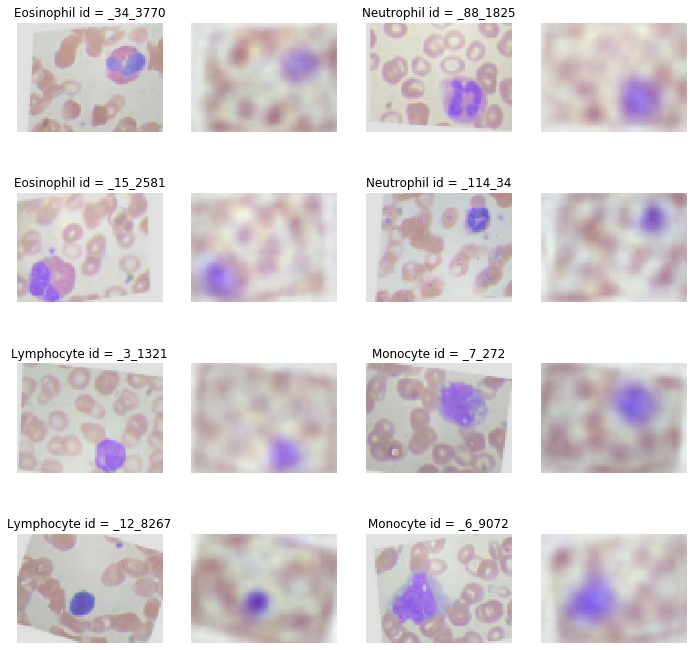

In [34]:
# plot some images before and after pca
# plot components 
# plot some of the augmented images

#train_index -> images selected for cross fold

fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(12, 12))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
n = 16
m1 = m2 = m3 = m4 = 0

for i in range(blood_under.shape[0]):
    if (blood_under.iloc[i,14402] == 1) & (m1<2): # first category  # & (i in train_index)
        m1 += 1
        current_id = blood_under.iloc[i,14401]         
        axes[m1-1,0].set_title("Eosinophil id = " + current_id)
        img = np.asarray(X_train.iloc[i,:]).reshape(60,80,3)
        axes[m1-1,0].imshow((img * 255).astype(np.uint8))
        axes[m1-1,0].axis('off')

        img = pca_projected[i].reshape(60,80,3)
        axes[m1-1,1].imshow((img * 255).astype(np.uint8))
        axes[m1-1,1].axis('off')
        
    if (blood_under.iloc[i,14402] == 2) & (m2<=1): # second category
        m2 += 1
        current_id = blood_under.iloc[i,14401]         
        axes[m2-1,2].set_title("Neutrophil id = " + current_id)
        img = np.asarray(X_train.iloc[i,:]).reshape(60,80,3)
        axes[m2-1,2].imshow((img * 255).astype(np.uint8))
        axes[m2-1,2].axis('off')

        img = pca_projected[i].reshape(60,80,3)
        axes[m2-1,3].imshow((img * 255).astype(np.uint8))        
        axes[m2-1,3].axis('off')
        
    if (blood_under.iloc[i,14402] == 3) & (m3<=1): # third category
        m3 += 1
        current_id = blood_under.iloc[i,14401]         
        axes[m3+1,0].set_title("Lymphocyte id = " + current_id)
        img = np.asarray(X_train.iloc[i,:]).reshape(60,80,3)
        axes[m3+1,0].imshow((img * 255).astype(np.uint8))
        axes[m3+1,0].axis('off')
        
        img = pca_projected[i].reshape(60,80,3)
        axes[m3+1,1].imshow((img * 255).astype(np.uint8))        
        axes[m3+1,1].axis('off')
        
    if (blood_under.iloc[i,14402] == 4) & (m4<=2): # fourth category
        m4 += 1
        current_id = blood_under.iloc[i,14401]         
        axes[m4,2].set_title("Monocyte id = " + current_id)
        img = np.asarray(X_train.iloc[i,:]).reshape(60,80,3)
        axes[m4,2].imshow((img * 255).astype(np.uint8))
        axes[m4,2].axis('off')
        
        img = pca_projected[i].reshape(60,80,3)
        axes[m4,3].imshow((img * 255).astype(np.uint8))        
        axes[m4,3].axis('off')
        
    if(m1>=2 & m2>=2 & m3>2 & m4>2):
        break

### Test different Models

We set up some possible models we can use for the classification problem and evaluate their results. We will use cross-validation to evaluate the models. 

**NOTE:** We have to keep in mind that we are working with augmented images that is training and validation set cannot be regarded as 100% independed as the same imgages augmented in a different way may be in the training and in the validation set. The only dataset really independent is the test set. Some tests showed that KNeighborsClassifier and SVC tend to overfit. When the number of *n_neighbors* is set too low, KNeighborsClassifier reaches very high values in training, but much lower in testing. The same is true for the values of gamma and *C* in *SVC*. That is why we have defined them different than the default values. 

In [24]:
# Define a list of possible models
clfs = [LogisticRegression(solver="lbfgs", random_state=42)
       , KNeighborsClassifier(n_neighbors= 15)#
       , GaussianNB()
       , SVC(C=10, random_state=42, gamma=0.001)#C=1, kernel="rbf", gamma='scale', random_state=42)
       , LinearSVC(random_state=42)
       , RandomForestClassifier(n_estimators=500, criterion="gini", max_depth=5, random_state=42)
       , AdaBoostClassifier(random_state=42)
       , XGBClassifier(random_state=42)]

In [25]:
# Function that performs cross validation and returns the desired metric(s)
# The metrics are stored in a dictionary
def model_evaluation_cv(X_train, y_train, clf, params_model=None, 
                     params_cross={"cv":5, "scoring":['accuracy','precision','recall','roc_auc','f1']}):
    
    # cross validation
    scores = cross_validate(clf, X_train, y_train, **params_cross)
    # return the list of all dictionary keys with mean values (mean over metrics from folds) 
    scores = {key: value.mean() for (key, value) in scores.items()}

    return scores

In [26]:
# Perform the model evaluation for all models in clf and cross folds
# Save the results in a dictionary, as follows: results ={'clf': {'cross_fold': {metrics}}}
kfold=5
results = {}
for clf in clfs:
    clf_name = clf.__class__.__name__
    scores = model_evaluation_cv(X_train = transformed_train, y_train = y_train, clf = clf)
    results[clf_name] = scores        
#print(results)

/Users/frauke/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/frauke/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/frauke/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/frauke/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/frauke/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to conver

In [27]:
# Function for the plots
# "results" is the dictionary containing the scores
# Remember: results = {'clf': {'cross_fold': {metrics}}

def plot_results(scores_mean, legend_labels, title='Model Comparison'):
    width = 0.5
    fig, ax = plt.subplots(figsize=(10,8))
    ax.set_facecolor((1.0, 250/255, 234/255))
    clfs = list(scores_mean.keys())
    x = np.arange(0, (len(clfs)+1)*(len(legend_labels)-2), len(clfs)+1)
    for clf in clfs:        
        score_list = []
        x+=1
        for score in scores_mean[clf]:
            if (score!="fit_time") and (score!="score_time"):
                #score_list contains all scores for one model
                score_list.append(scores_mean[clf][score])
        rects1 = ax.bar(x - width/2, score_list, width, label=clf, alpha=1)
        ax.set_ylabel('score')
        ax.set_title(title)
        ax.set_ylim(0.5,1)
        ax.set_xticks(x-len(clfs)/2)
        ax.set_xticklabels(score_labels[2:])
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=3, fancybox=True)

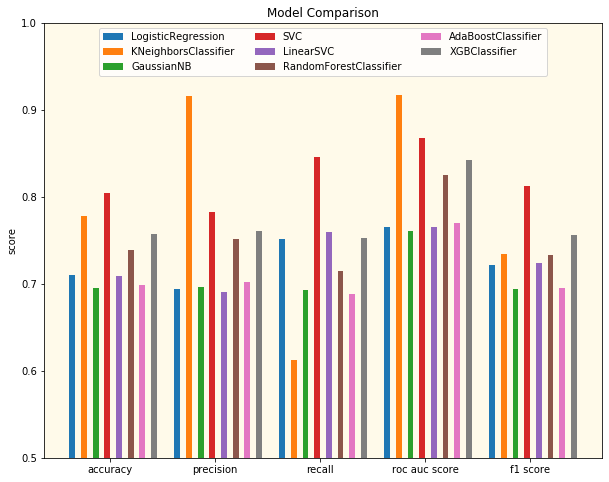

In [28]:
score_labels = ["fit time", "score time", "accuracy", "precision", "recall", "roc auc score", "f1 score"]
plot_results(results, score_labels)

In [29]:
#store scores in dataframe
def df_scores(scores_mean, legend_labels):
    
    clfs    = list(scores_mean.keys())
    metrics = legend_labels
    data = { "metric": [metrics[0], metrics[1], metrics[2], metrics[3], metrics[4], metrics[5], metrics[6]]}
    df = pd.DataFrame (data, columns = ["metric"])
    x = np.arange(0, (len(legend_labels)+2)*(len(legend_labels)+1), len(clfs)+2)
    for clf in clfs:   
        score_list = []
        x += 1
        for score in scores_mean[clf]:
            score_list.append(round(scores_mean[clf][score],3))
        df[clf] = score_list 
    return df

In [30]:
score_labels = ["fit time", "score time","accuracy", "precision", "recall", "roc auc score", "f1 score"]
scores_df = df_scores(results,score_labels).set_index("metric")
scores_df

,LogisticRegression,KNeighborsClassifier,GaussianNB,SVC,LinearSVC,RandomForestClassifier,AdaBoostClassifier,XGBClassifier
metric,,,,,,,,
fit time,0.097,0.029,0.026,3.273,2.550,12.233,5.091,9.071
score time,0.020,3.749,0.012,1.180,0.011,0.252,0.054,0.031
accuracy,0.710,0.778,0.695,0.805,0.709,0.739,0.698,0.758
precision,0.694,0.916,0.697,0.782,0.691,0.751,0.702,0.760
recall,0.752,0.613,0.693,0.846,0.760,0.715,0.688,0.752
roc auc score,0.766,0.917,0.760,0.868,0.765,0.825,0.770,0.843
f1 score,0.722,0.734,0.694,0.813,0.723,0.733,0.695,0.756


## Hyperparameter Tuning

We see that the two models **KNeighborClassifier** and **SVC** give the best results. However, as we have seen in some tests (not shown) these models tend to overfit. The parameters of *n_neighbors*, *C* and *gamma* are therefore on purpose only set in a certain intervall for the gridsearch. We also consider the **RandomForestClassifier** and **XGBClassifier** for further parameter tuning. We tune the models towards **accuracy**.

In [31]:
# Decide for 4 models
clfs_sel = [SVC(C=1, kernel="rbf", gamma='scale', random_state=42)
            , KNeighborsClassifier(n_neighbors=5)
            , RandomForestClassifier(random_state=42)
            , XGBClassifier(random_state=42)]

param_sets = [
              # parameters for svc
                { 'kernel': ['poly','rbf']
                , 'C': [10, 100, 1000]
                , 'gamma':[0.001, 0.0001]
                , 'probability':[True]}
                #, 'n_jobs':[-1]}  
              # parameters for knn  
                , { 'n_neighbors': [10, 15, 20]
                , 'weights': ['uniform','distance']
                , 'leaf_size':[10,30,50]
                , 'p':[1,2,3]}
                #, 'n_jobs':[-1]} 
              # parameters for RandomForest
                 , { 'n_estimators':[200, 300, 400, 500]
                 , 'criterion':['gini', 'entropy']
                 , 'max_depth':[2, 4, 6, 8, 10]
                 , 'n_jobs':[-1]}
              # parameters for XGBoost
                 , {'n_estimators': [100, 300, 500]
                 , 'max_depth': [4, 6, 8]
                 , 'learning_rate': [0.5, 0.1, 0.01, 0.05]
                 , 'colsample_bytree': [1]
                 , 'min_child_weight' : [1]
                 , 'gamma'            : [ 0.0, 0.2 , 0.4 ]
                 , 'n_jobs':[-1]}  
            ]

In [32]:
# Gridsearch with scoring roc_auc, returns the best estimator
def grid_search(X_train, y_train, clf, param):
    #CLF = GridSearchCV(clf, param, scoring='roc_auc', n_jobs=-1, cv=5)
    CLF = GridSearchCV(clf, param, scoring='accuracy', n_jobs=-1, cv=5)
    best_clf = CLF.fit(X_train, y_train)
    return best_clf.best_estimator_

In [33]:
def grid_search_res(X_train, y_train, clfs, param_sets):
    # perform the grid-search over all scenarios and all classifiers
    # and save the results in a dictionary: grid_search_results = {clf: {}}
    grid_search_results = {}
    for clf, param_set in zip(clfs_sel, param_sets):
        #print(clf.__class__.__name__)
        #print(param_set)
        grid_search_results[clf.__class__.__name__] = grid_search(X_train, y_train, clf, param_set)
    # evaluate the best classifiers and return the scores
    # safe scores in a dictionary: grid_search_scores = {clf: {scores}}
    #print(grid_search_results)
    grid_search_scores = {}
    for clf in clfs:
        clf_name = clf.__class__.__name__
        scores = model_evaluation_cv(X_train, y_train, clf)
        grid_search_scores[clf_name] = scores 
    #print(grid_search_scores)
    return grid_search_results, grid_search_scores

In [100]:
grid_search_results, grid_search_scores = grid_search_res(transformed_train, y_train, clfs_sel, param_sets)

SVC
{'kernel': ['poly', 'rbf'], 'C': [10, 100, 1000], 'gamma': [0.001, 0.0001], 'probability': [True]}
KNeighborsClassifier
{'n_neighbors': [10, 15, 20], 'weights': ['uniform', 'distance'], 'leaf_size': [10, 30, 50], 'p': [1, 2, 3]}
RandomForestClassifier
{'n_estimators': [200, 300, 400, 500], 'criterion': ['gini', 'entropy'], 'max_depth': [2, 4, 6, 8, 10], 'n_jobs': [-1]}
XGBClassifier
{'n_estimators': [100, 300, 500], 'max_depth': [4, 6, 8], 'learning_rate': [0.5, 0.1, 0.01, 0.05], 'colsample_bytree': [1], 'min_child_weight': [1], 'gamma': [0.0, 0.2, 0.4], 'n_jobs': [-1]}
{'SVC': SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='poly',
    max_iter=-1, probability=True, random_state=42, shrinking=True, tol=0.001,
    verbose=False), 'KNeighborsClassifier': KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=

In [101]:
best_models = grid_search_results
best_models

{'SVC': SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma=0.001, kernel='poly',
     max_iter=-1, probability=True, random_state=42, shrinking=True, tol=0.001,
     verbose=False),
 'KNeighborsClassifier': KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='minkowski',
                      metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                      weights='distance'),
 'RandomForestClassifier': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='entropy', max_depth=10, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=400,
                        n_jobs=-1, oob_score=False, random_state=42,

In [102]:
grid_search_scores

{'SVC': {'fit_time': 5.1894996643066404,
  'score_time': 2.0912195682525634,
  'test_accuracy': 0.8642758869430074,
  'test_precision': 0.8374109859493515,
  'test_recall': 0.9045450120075291,
  'test_roc_auc': 0.9358354171893174,
  'test_f1': 0.8695716344444678},
 'KNeighborsClassifier': {'fit_time': 0.06841912269592285,
  'score_time': 4.532101058959961,
  'test_accuracy': 0.8769638981927821,
  'test_precision': 0.8952689613649563,
  'test_recall': 0.8542164275978452,
  'test_roc_auc': 0.9468243745591611,
  'test_f1': 0.8740922318862806},
 'RandomForestClassifier': {'fit_time': 6.559440612792969,
  'score_time': 0.09662098884582519,
  'test_accuracy': 0.785542459186134,
  'test_precision': 0.7718077623911235,
  'test_recall': 0.812732848705134,
  'test_roc_auc': 0.8732676377274486,
  'test_f1': 0.7913761700145742},
 'XGBClassifier': {'fit_time': 11.418882417678834,
  'score_time': 0.03747100830078125,
  'test_accuracy': 0.7539286068880554,
  'test_precision': 0.756695792949632,
  'te

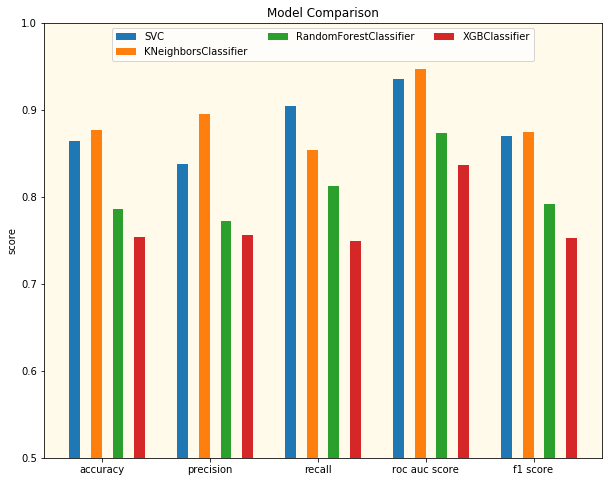

In [103]:
# plot scores
score_labels = ["fit time", "score time", "accuracy", "precision", "recall", "roc auc score", "f1 score"]
plot_results(grid_search_scores, score_labels)

In [104]:
score_labels = ["fit time", "score time","accuracy", "precision", "recall", "roc auc score", "f1 score"]
scoresh_df = df_scores(grid_search_scores,score_labels).set_index("metric")
scoresh_df

,SVC,KNeighborsClassifier,RandomForestClassifier,XGBClassifier
metric,,,,
fit time,5.189,0.068,6.559,11.419
score time,2.091,4.532,0.097,0.037
accuracy,0.864,0.877,0.786,0.754
precision,0.837,0.895,0.772,0.757
recall,0.905,0.854,0.813,0.749
roc auc score,0.936,0.947,0.873,0.836
f1 score,0.870,0.874,0.791,0.753


KneighborsClassifier and SVC both achieve very good results for all metrics, especially the auc score. However, as mentioned above we have to keep in mind that the cross-validation is not 100% independent and both models showed problems in overfitting while testing (not shown). 

As our final model we will use a stacked model from these four models. The stacking is done via logarithmic regression.

## Evaluate Model on Test Set

Before evaluating the results on the test data has to be brought in the same format as our train data is. That is the feature engineering part from notebook 1. A function to convert the test data into the needed format is given in notebook 1. Here we assume that we already have the desired format. That is we only have to apply the pca and the model.

We use stacking to use the best performing model for prediction.

### Read the test Data

In [146]:
# read kaggle test set
X_class1E_kaggle = pd.read_csv(path_test_csv + 'test_class1_E.csv')
X_class2N_kaggle = pd.read_csv(path_test_csv + 'test_class2_N.csv')
X_class3L_kaggle = pd.read_csv(path_test_csv + 'test_class3_L.csv')
X_class4M_kaggle = pd.read_csv(path_test_csv + 'test_class4_M.csv')
# save all in 1 dataframe and delete the others
X_test_kaggle = X_class1E_kaggle.copy()
X_test_kaggle = X_test_kaggle.append(X_class2N_kaggle)
del X_class1E_kaggle
X_test_kaggle = X_test_kaggle.append(X_class3L_kaggle)
del X_class2N_kaggle
X_test_kaggle = X_test_kaggle.append(X_class4M_kaggle)
del X_class3L_kaggle
del X_class4M_kaggle
X_test_kaggle.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,14397,14398,14399,id,class,classE,classN,classL,classM,granulocyte
0,dataset2-master/dataset2-master/images/TEST/EO...,0.797059,0.836275,0.797059,0.806863,0.839216,0.801961,0.814706,0.842157,0.806863,...,0.882353,0.882353,0.882353,_11_6757,1,1,0,0,0,1
1,dataset2-master/dataset2-master/images/TEST/EO...,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,...,0.882353,0.882353,0.882353,_7_986,1,1,0,0,0,1
2,dataset2-master/dataset2-master/images/TEST/EO...,0.792157,0.792157,0.797059,0.787255,0.781373,0.782353,0.800000,0.786275,0.778431,...,0.882353,0.882353,0.882353,_3_9885,1,1,0,0,0,1
3,dataset2-master/dataset2-master/images/TEST/EO...,0.866667,0.864706,0.864706,0.791176,0.749020,0.733333,0.756863,0.622549,0.590196,...,0.882353,0.882353,0.882353,_11_3152,1,1,0,0,0,1
4,dataset2-master/dataset2-master/images/TEST/EO...,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,...,0.799020,0.785294,0.768627,_2_1953,1,1,0,0,0,1


In [279]:
X_test_kaggle.reset_index(inplace=True,drop=True)
X_test_kaggle.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,14397,14398,14399,id,class,classE,classN,classL,classM,granulocyte
0,dataset2-master/dataset2-master/images/TEST/EO...,0.797059,0.836275,0.797059,0.806863,0.839216,0.801961,0.814706,0.842157,0.806863,...,0.882353,0.882353,0.882353,_11_6757,1,1,0,0,0,1
1,dataset2-master/dataset2-master/images/TEST/EO...,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,...,0.882353,0.882353,0.882353,_7_986,1,1,0,0,0,1
2,dataset2-master/dataset2-master/images/TEST/EO...,0.792157,0.792157,0.797059,0.787255,0.781373,0.782353,0.800000,0.786275,0.778431,...,0.882353,0.882353,0.882353,_3_9885,1,1,0,0,0,1
3,dataset2-master/dataset2-master/images/TEST/EO...,0.866667,0.864706,0.864706,0.791176,0.749020,0.733333,0.756863,0.622549,0.590196,...,0.882353,0.882353,0.882353,_11_3152,1,1,0,0,0,1
4,dataset2-master/dataset2-master/images/TEST/EO...,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,...,0.799020,0.785294,0.768627,_2_1953,1,1,0,0,0,1


In [148]:
X_test_kaggle.iloc[:,1:14401].head()

,0,1,2,3,4,5,6,7,8,9,...,14390,14391,14392,14393,14394,14395,14396,14397,14398,14399
0,0.797059,0.836275,0.797059,0.806863,0.839216,0.801961,0.814706,0.842157,0.806863,0.821569,...,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353
1,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,...,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353
2,0.792157,0.792157,0.797059,0.787255,0.781373,0.782353,0.800000,0.786275,0.778431,0.782353,...,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353
3,0.866667,0.864706,0.864706,0.791176,0.749020,0.733333,0.756863,0.622549,0.590196,0.756863,...,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353
4,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,0.882353,...,0.698039,0.692157,0.662745,0.676471,0.734314,0.713725,0.705882,0.799020,0.785294,0.768627


In [149]:
X_test_kaggle.iloc[:,14405].head()

0    0
1    0
2    0
3    0
4    0
Name: classL, dtype: int64

In [150]:
X_testK = X_test_kaggle.iloc[:,1:14401]
y_testK = X_test_kaggle.iloc[:,14405]

### Build Pipeline for Predictions

We stack the four models and before applying them we apply the PCA. We put all together in a pipeline. We apply this pipeline to the test set and have a look at the metrics. We achieve an **accuracy of 0.77** and an **auc score of 0.75**.

In [280]:
pca = PCA(n_components=0.8,svd_solver = 'full')

In [115]:
# stacking
clf1 = grid_search_results['SVC']
clf2 = grid_search_results['KNeighborsClassifier']
clf3 = grid_search_results['RandomForestClassifier']
clf4 = grid_search_results['XGBClassifier']

lr = LogisticRegression()

sclf = StackingClassifier(classifiers=[clf1, clf2, clf3, clf4],
                          use_probas=True,
                          average_probas=False,
                          meta_classifier=lr)

In [116]:
pipe_clf = Pipeline([
    ('pca',pca),
    ('clf',sclf)
    ])
pipe_clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=0.8,
                     random_state=None, svd_solver='full', tol=0.0,
                     whiten=False)),
                ('clf',
                 StackingClassifier(average_probas=False,
                                    classifiers=[SVC(C=1000, break_ties=False,
                                                     cache_size=200,
                                                     class_weight=None,
                                                     coef0=0.0,
                                                     decision_function_shape='ovr',
                                                     degree=3, gamma=0.001,
                                                     kernel='poly', max_ite...
                                    meta_classifier=LogisticRegression(C=1.0,
                                                                       class_weight=None,
   

In [117]:
y_kaggle_pred  = pipe_clf.predict(X_testK)
y_kaggle_score = pipe_clf.predict_proba(X_testK)[:,1]

In [119]:
# calculate scores
print('test accuracy: {:.2f}'.format(accuracy_score(y_true=y_testK, y_pred=y_kaggle_pred)))
print('precision: {:.2f}'.format(precision_score(y_true=y_testK, y_pred=y_kaggle_pred)))
print('recall: {:.2f}'.format(recall_score(y_true=y_testK, y_pred=y_kaggle_pred)))
print('roc auc Score: {:.2f}'.format(roc_auc_score(y_true=y_testK, y_score=y_kaggle_score)))
print('f1: {:.2f}'.format(f1_score(y_true=y_testK, y_pred=y_kaggle_pred)))

test accuracy: 0.77
precision: 0.55
recall: 0.39
roc auc Score: 0.75
f1: 0.46


roc auc score: 0.75 


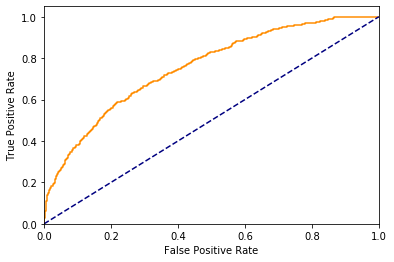

In [120]:
# roc curve
fpr, tpr, threshold = roc_curve(y_testK, y_kaggle_score)
plt.plot(fpr, tpr, color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print("roc auc score: {} ".format(round(roc_auc_score(y_testK, y_kaggle_score),2)))

In [121]:
# confusion matrix
confusion_matrix(y_true=y_testK, y_pred=y_kaggle_pred)

array([[1674,  193],
       [ 380,  240]])

In [122]:
# classification_report
print(classification_report(y_true=y_testK, y_pred=y_kaggle_pred))

              precision    recall  f1-score   support

           0       0.81      0.90      0.85      1867
           1       0.55      0.39      0.46       620

    accuracy                           0.77      2487
   macro avg       0.68      0.64      0.65      2487
weighted avg       0.75      0.77      0.75      2487



### Analyse the Scores

Have a closer look at the scores. Especially at the number of observations that have been labeled with 0 , but with a probability of more than 0.4 and less than 0.1, respectivley. The large majority of these observations have a probability of less than 0.1, which means that the model is "quite sure" in its decision. Analogue for the observations labeled with 1. Although in the latter case the ratio of "unsure" predictions is higher.

In [123]:
# have a closer look at the scores
y_kaggle_score

array([0.00662371, 0.0028181 , 0.04354423, ..., 0.00157225, 0.01259993,
       0.00082891])

In [124]:
# have a closer look at the scores
sc_0  = [round(sc,3) for sc in y_kaggle_score if sc <= 0.5]
sc_01 = [round(sc,3) for sc in sc_0 if sc > 0.4]
sc_02 = [round(sc,3) for sc in sc_0 if sc < 0.1]
print('classified as 0:')
print(len(sc_0))
print('classified as 0 with probability of more than 0.4:')
print(len(sc_01))
print('classified as 0 with probability of less than 0.1:')
print(len(sc_02))

classified as 0:
2054
classified as 0 with probability of more than 0.4:
51
classified as 0 with probability of less than 0.1:
1810


In [125]:
# have a closer look at the scores
sc_1 = [round(sc,3) for sc in y_kaggle_score if sc > 0.5]
sc_11 = [round(sc,3) for sc in sc_1 if sc < 0.6]
sc_12 = [round(sc,3) for sc in sc_1 if sc > 0.9]
print('classified as 1:')
print(len(sc_1))
print('classified as 0 with probability of more than 0.9:')
print(len(sc_12))
print('classified as 0 with probability of less than 0.6:')
print(len(sc_11))

classified as 1:
433
classified as 0 with probability of more than 0.9:
238
classified as 0 with probability of less than 0.6:
42


### Predictions per Class 

We have a look at the number of true and predicted values in each class. We see that most mistakes are made in predicting a lymphocyte as no lymphocyte. This fits to the low recall rate we achieve in the model.

In [152]:
# eosinophil 
x1 = X_test_kaggle.iloc[0:623,1:14401]
y1 = X_test_kaggle.iloc[0:623,14405]
y1_pred  = pipe_clf.predict(x1)
y1_score = pipe_clf.predict_proba(x1)[:,1]
#print("Image id:{}".format(X_test_kaggle.iloc[0:626,14401]))
print("True value: {}".format(X_test_kaggle.iloc[0:623,14405].sum()))
print("Prediction: {}".format(y1_pred.sum()))
#print("Prediction score: {:.3f}".format(y1_score))

True value: 0
Prediction: 142


In [276]:
# nithrophil 
x2 = X_test_kaggle.iloc[624:1247,1:14401]
y2 = X_test_kaggle.iloc[624:1247,14405]
y2_pred  = pipe_clf.predict(x2)
y2_score = pipe_clf.predict_proba(x2)[:,1]
#print("Image id:{}".format(X_test_kaggle.iloc[0:627,14401]))
print("True value: {}".format(X_test_kaggle.iloc[624:1247,14405].sum()))
print("Prediction: {}".format(y2_pred.sum()))
#print("Prediction score: {:.3f}".format(y1_score))

True value: 0
Prediction: 48


In [277]:
# lymphocyte 
x3 = X_test_kaggle.iloc[1248:1868,1:14401]
y3 = X_test_kaggle.iloc[1248:1868,14405]
y3_pred  = pipe_clf.predict(x3)
y3_score = pipe_clf.predict_proba(x3)[:,1]
#print("Image id:{}".format(X_test_kaggle.iloc[0:627,14401]))
print("True value: {}".format(X_test_kaggle.iloc[1248:1871,14405].sum()))
print("Prediction: {}".format(y3_pred.sum()))
#print("Prediction score: {:.3f}".format(y1_score))

True value: 619
Prediction: 240


In [278]:
# monocyte 
x4 = X_test_kaggle.iloc[1869:2487,1:14401]
y4 = X_test_kaggle.iloc[1869:2487,14405]
y4_pred  = pipe_clf.predict(x4)
y4_score = pipe_clf.predict_proba(x4)[:,1]
#print("Image id:{}".format(X_test_kaggle.iloc[0:627,14401]))
print("True value: {}".format(X_test_kaggle.iloc[1871:2491,14405].sum()))
print("Prediction: {}".format(y4_pred.sum()))
#print("Prediction score: {:.3f}".format(y1_score))

True value: 0
Prediction: 3


## Summary & Conclusions

We see that the model is overfitting. That is the accuracy is lower on the test set than on the training set, however we still reach an **accurray of 0.77**. This is propably due to the data construction. We are working with augmented images in the training set. However, the augmented images share a lot of information, that is the validation datasets during cross-validation is not independend from the training set. In contrast to that the test data is completely independed. The original images have been separated in train and test datasets and then augmented. A way to prevent this overfitting would be to train only the original images. However, there are only about 400 images and only about 25 images from the class lymphocyte. 

Further the Recall is low for our model. Most of the error in the model occurs due to classifying lymphocytes as no lymphocytes.

## Outlook

In the next notebook (04) we will consider the classification of all four types of blood cells. In contrast to this notebook, we will use a CNN.